# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# colab libraries
from google.colab import drive
from google.colab.patches import cv2_imshow

import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Seeding

In [3]:
torch.manual_seed(784)

In [4]:
np.random.seed(54)

# Data Processing

## Mount Drive

In [5]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
BASE_PATH = '/content/drive/MyDrive/DL Project/Project Dataset'
TRAIN_PATH = BASE_PATH + '/train_unzipped'
TRAIN_LABEL_PATH = BASE_PATH + '/train_label_unzipped'
VAL_PATH = BASE_PATH + '/val_unzipped'
VAL_LABEL_PATH = BASE_PATH + '/val_label_unzipped'

## Load Data

In [7]:
def import_data(INPUT_PATH: str, LABEL_PATH: str, final_dimension: tuple, input_id_index : tuple, label_id_index : tuple, is_val: bool = False):

    inputs = []
    labels = []

    files = os.listdir(INPUT_PATH)
    label_files = os.listdir(LABEL_PATH)

    for index, file in enumerate(files):
        
        if (not is_val) and index % 3 > 0:
            continue

        try:
            idx = (int) (file[ input_id_index[0] : input_id_index[1] ])
        except:
            continue

        image = cv2.imread(INPUT_PATH+"/"+file)
        image = cv2.resize(image, final_dimension)
        inputs.append(image)

        for label_file in label_files:
        
            label_idx = (int)(label_file[ label_id_index[0] : label_id_index[1] ])

            if(idx == label_idx):
                label_image = cv2.imread(LABEL_PATH+"/"+label_file)
                label_image = cv2.resize(label_image, final_dimension)
                labels.append(label_image)
                break

    inputs = np.array(inputs)
    inputs = inputs/255
    labels = np.array(labels)
    labels = labels/255

    return (inputs, labels)

In [8]:
reduced_dims = (192, 96)

In [9]:
# the below 4 variables denotes the idx indices for the file names

train_input_id_index = (44, -4)   # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png
train_label_id_index = (44, -10)  # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png

val_input_id_index = (44, -19)    # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png
val_label_id_index = (44, -25)    # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set_label.png

In [10]:
train_x, train_y = import_data(TRAIN_PATH, TRAIN_LABEL_PATH, reduced_dims, train_input_id_index, train_label_id_index)
val_x, val_y = import_data(VAL_PATH, VAL_LABEL_PATH, reduced_dims, val_input_id_index, val_label_id_index, True)

In [11]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(1026, 96, 192, 3) (1026, 96, 192, 3)
(129, 96, 192, 3) (129, 96, 192, 3)


## Data Visualising

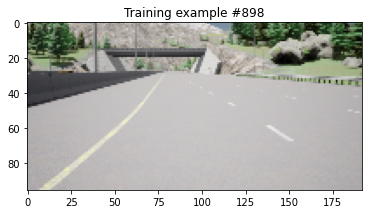

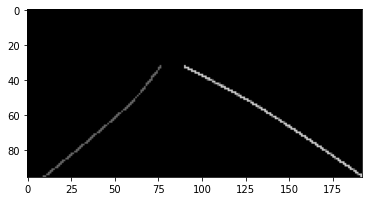

In [12]:
i = np.random.randint(0, len(train_x))
plt.imshow(train_x[i])
plt.title(f"Training example #{i}")
plt.show()
plt.imshow(train_y[i]*100)
plt.show()

# Model Architecture

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[32, 64, 128, 256],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        x = self.final_conv(x)
        return self.sigmoid(x)

#### Model Summary

In [14]:
input_dim = (3, 96, 192)

In [15]:
from torchsummary import summary
testing_model = UNET()

# while working on GPU
summary(testing_model.cuda(), input_dim)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 96, 192]             864
       BatchNorm2d-2          [-1, 32, 96, 192]              64
              ReLU-3          [-1, 32, 96, 192]               0
            Conv2d-4          [-1, 32, 96, 192]           9,216
       BatchNorm2d-5          [-1, 32, 96, 192]              64
              ReLU-6          [-1, 32, 96, 192]               0
        DoubleConv-7          [-1, 32, 96, 192]               0
         MaxPool2d-8           [-1, 32, 48, 96]               0
            Conv2d-9           [-1, 64, 48, 96]          18,432
      BatchNorm2d-10           [-1, 64, 48, 96]             128
             ReLU-11           [-1, 64, 48, 96]               0
           Conv2d-12           [-1, 64, 48, 96]          36,864
      BatchNorm2d-13           [-1, 64, 48, 96]             128
             ReLU-14           [-1, 64,

# Ground 

## Train Preprocessing

In [16]:
train_y.shape

(1026, 96, 192, 3)

In [17]:
n, h, w, c = train_y.shape          # 1026 x 96 x 192 x 3
shape_ground = (n, h, w, 1)

In [18]:
ground = np.zeros(shape=shape_ground)   # 1026 x 96 x 192 x 1
back_ground_limit = 0.0

In [19]:
def get_ground_for_each_train(y_train):
    n, h, w, c = y_train.shape          # 1026 x 96 x 192 x 3
    for i in range(n):
        ground[i] = np.where(np.mean(y_train[i], axis=2, keepdims=True) <= back_ground_limit, 0, 1)
    return 

In [20]:
get_ground_for_each_train(train_y)

In [21]:
ground.shape

(1026, 96, 192, 1)

##### Train Ground Visual 

In [22]:
broad_caster = broad_caster = np.ones(shape=(96, 192, 3))

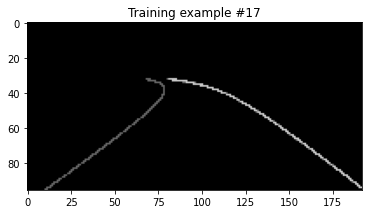

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


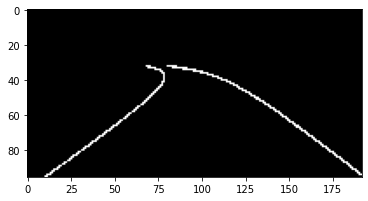

In [23]:
i = np.random.randint(0, len(train_y))
plt.imshow(train_y[i]*100)
plt.title(f"Training example #{i}")
plt.show()
plt.imshow(ground[i]*broad_caster*100)
plt.show()

## Validation Preprocessing

In [24]:
n, h, w, c = val_y.shape          # 1026 x 96 x 192 x 3
shape_val = (n, h, w, 1)

In [25]:
val_ground = np.zeros(shape=shape_val)

In [26]:
def get_ground_for_each_val(y_test):
    n, h, w, c = y_test.shape          # 1026 x 96 x 192 x 3
    for i in range(n):
        val_ground[i] = np.where(np.mean(y_test[i], axis=2, keepdims=True) <= back_ground_limit, 0, 1)
    return 

In [27]:
get_ground_for_each_val(val_y)

In [28]:
val_ground.shape

(129, 96, 192, 1)

# Loss Function

In [29]:
ALPHA = 0.5
BETA = 0.5
epsilon = 1e-6

#### IoU Loss

In [30]:
class IoULoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, epsilon=1e-6):
        super(IoULoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon

    def forward(self, targets, inputs):
        # batch_size x 1 x 96 x 192

        #flatten label and prediction tensors
        inputs = torch.flatten(inputs)
        targets = torch.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = torch.sum(targets * inputs)
        FP = torch.sum((1-targets) * inputs)
        FN = torch.sum(targets * (1-inputs))  # wrong lanes 
        
        IoULoss = (TP + self.epsilon) / (TP + self.alpha*FP + self.beta*FN + self.epsilon) 
        return 1-IoULoss

# Learning

#### Hyperparameters

In [31]:
lr = 0.01
batch_size = 16
momentum = 0.2
epochs = 200
epsilon = 1e-6

#### Shapes

In [32]:
print(train_x.shape , train_y.shape)

(1026, 96, 192, 3) (1026, 96, 192, 3)


In [33]:
print(val_x.shape, val_y.shape)

(129, 96, 192, 3) (129, 96, 192, 3)


In [34]:
print(ground.shape)

(1026, 96, 192, 1)


In [35]:
print(val_ground.shape)

(129, 96, 192, 1)


#### Model Initialisation

In [36]:
model = UNET().to(device)

#### Optimizer

In [37]:
optimizer = optim.SGD(model.parameters(), lr, momentum)

#### Loss Class

In [39]:
iou_loss = IoULoss(alpha=ALPHA, beta=BETA, epsilon=epsilon)

#### Weight Initializer

In [40]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, 1)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 0, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0, 1)
        nn.init.constant_(m.bias.data, 0)

#### Training and Validation

In [41]:
train_losses = []
validation_losses = []

In [42]:
model.train()
model.apply(initialize_weights)

n = len(train_x)

for epoch in range(epochs):

    train_loss = 0.0

    for i in range( n//batch_size ):

        optimizer.zero_grad()

        input = torch.from_numpy(train_x[i*batch_size: i*batch_size+batch_size]).float()
        input = input.to(device)

        # changing from batch_size x 96 x 192 x 3 to batch_size x 3 x 96 x 192
        input = input.transpose(1, 3)
        input = input.transpose(2, 3)

        # batch_size x 96 x 192 x 7
        output = torch.from_numpy(ground[i*batch_size: i*batch_size+batch_size]).float()
        output = output.to(device)

        # changing from batch_size x 96 x 192 x 1 to batch_size x 1 x 96 x 192
        output = output.transpose(1, 3)
        output = output.transpose(2, 3)

        # forward
        predictions = model(input)                  # batch_size x 1 x 96 x 192
        loss = iou_loss(output, predictions)

        # backward
        loss.backward()
        optimizer.step()

        # update losses
        train_loss += loss.item()

    print("Loss after epoch " + str(epoch) + " is : " + str(loss.item()))
    train_losses.append(train_loss)


Loss after epoch 0 is : 0.9758707880973816
Loss after epoch 1 is : 0.9750398993492126
Loss after epoch 2 is : 0.9742727279663086
Loss after epoch 3 is : 0.9735674858093262
Loss after epoch 4 is : 0.97291100025177
Loss after epoch 5 is : 0.9722796678543091
Loss after epoch 6 is : 0.9716761708259583
Loss after epoch 7 is : 0.9710915684700012
Loss after epoch 8 is : 0.9705162644386292
Loss after epoch 9 is : 0.9699487686157227
Loss after epoch 10 is : 0.9693914651870728
Loss after epoch 11 is : 0.9688562750816345
Loss after epoch 12 is : 0.9683390259742737
Loss after epoch 13 is : 0.9678459167480469
Loss after epoch 14 is : 0.9673748016357422
Loss after epoch 15 is : 0.9669287204742432
Loss after epoch 16 is : 0.9665097594261169
Loss after epoch 17 is : 0.9661126136779785
Loss after epoch 18 is : 0.9657438397407532
Loss after epoch 19 is : 0.9653958082199097
Loss after epoch 20 is : 0.9650688767433167
Loss after epoch 21 is : 0.964759886264801
Loss after epoch 22 is : 0.9644646048545837
L

In [43]:
validation_accuracy = []

In [45]:
model.eval()

num_correct = 0.0
num_pixels = 0.0

m = len(val_x)
_, h, w, _ = ground.shape

with torch.no_grad():
    for i in range(m):

        input = torch.from_numpy(val_x[i]).float()
        input = torch.unsqueeze(input, axis = 0)
        input = input.to(device)

        # # changing from 1 x 96 x 192 x 3 to 1 x 3 x 96 x 192
        input = input.transpose(1, 3)
        input = input.transpose(2, 3)

        # 1 x 1 x 96 x 192
        output = torch.from_numpy(val_ground[i]).float()
        output = torch.unsqueeze(output, axis = 0)
        output = output.to(device)

        output = output.transpose(1, 3)
        output = output.transpose(2, 3)
        output = output[:, 0:1, :, :]

        predictions = model(input)
        
        loss = iou_loss(predictions, output)
        validation_losses.append(loss.item())

        predictions = torch.where(predictions >= 0.5, 1, 0)

        num_correct = (predictions == output).type(torch.float).sum().item()
        num_pixels = (float) (h*w)
        
        validation_accuracy.append((num_correct / num_pixels))

        print("# of White : " + str((output != 0).sum().item()) + ", # of Black : " + str((output == 0).sum().item()))
        print("Correctly Predicted : " + str(num_correct) + ", Wrongly Predicted : " + str(num_pixels - num_correct))

        print("Accuracy for validation Sample " + str(i) + " is :" + str(num_correct / num_pixels))

# of White : 264, # of Black : 18168
Correctly Predicted : 18249.0, Wrongly Predicted : 183.0
Accuracy for validation Sample 0 is :0.9900716145833334
# of White : 307, # of Black : 18125
Correctly Predicted : 18218.0, Wrongly Predicted : 214.0
Accuracy for validation Sample 1 is :0.9883897569444444
# of White : 258, # of Black : 18174
Correctly Predicted : 18280.0, Wrongly Predicted : 152.0
Accuracy for validation Sample 2 is :0.9917534722222222
# of White : 282, # of Black : 18150
Correctly Predicted : 18285.0, Wrongly Predicted : 147.0
Accuracy for validation Sample 3 is :0.9920247395833334
# of White : 287, # of Black : 18145
Correctly Predicted : 18304.0, Wrongly Predicted : 128.0
Accuracy for validation Sample 4 is :0.9930555555555556
# of White : 294, # of Black : 18138
Correctly Predicted : 18187.0, Wrongly Predicted : 245.0
Accuracy for validation Sample 5 is :0.9867078993055556
# of White : 242, # of Black : 18190
Correctly Predicted : 18245.0, Wrongly Predicted : 187.0
Accura

#### Results

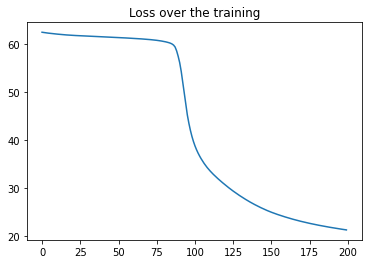

In [46]:
plt.title(f"Loss over the training")
plt.plot(train_losses)
plt.show()

In [47]:
print("Validation Loss : " + str(sum(validation_losses)/len(validation_losses)))

Validation Loss : 0.37675525883371513


In [48]:
print("Validation Accuracy : " + str(sum(validation_accuracy)/len(validation_accuracy)))

Validation Accuracy : 0.9909657454511199


# Ouput Visualisation

In [49]:
sample_number = np.random.randint(129)

#### Process

In [50]:
with torch.no_grad():
    input = torch.from_numpy(val_x[sample_number]).float()
    input = torch.unsqueeze(input, axis = 0)
    input = input.to(device)

    # # changing from 10 x 96 x 192 x 3 to 10 x 3 x 96 x 192
    input = input.transpose(1, 3)
    input = input.transpose(2, 3)

    # 10 x 1 x 96 x 192
    output = torch.from_numpy(val_ground[sample_number]).float()
    output = torch.unsqueeze(output, axis = 0)
    output = output.to(device)

    output = output.transpose(1, 3)
    output = output.transpose(2, 3)

    predictions = model(input)
    predictions = torch.where(predictions >= 0.5, 1, 0)

    num_correct = (predictions == output).type(torch.float).sum().item()
    num_pixels = (float) (h*w)

    print("# of White : " + str((output != 0).sum().item()) + ", # of Black : " + str((output == 0).sum().item()))
    print("Correctly Predicted : " + str(num_correct) + ", Wrongly Predicted : " + str(num_pixels - num_correct))

    print("Accuracy for validation Sample " + str(i) + " is :" + str(num_correct / num_pixels))

# of White : 286, # of Black : 18146
Correctly Predicted : 18323.0, Wrongly Predicted : 109.0
Accuracy for validation Sample 128 is :0.9940863715277778


#### Visuals

In [51]:
broad_caster = np.ones(shape=(96, 192, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

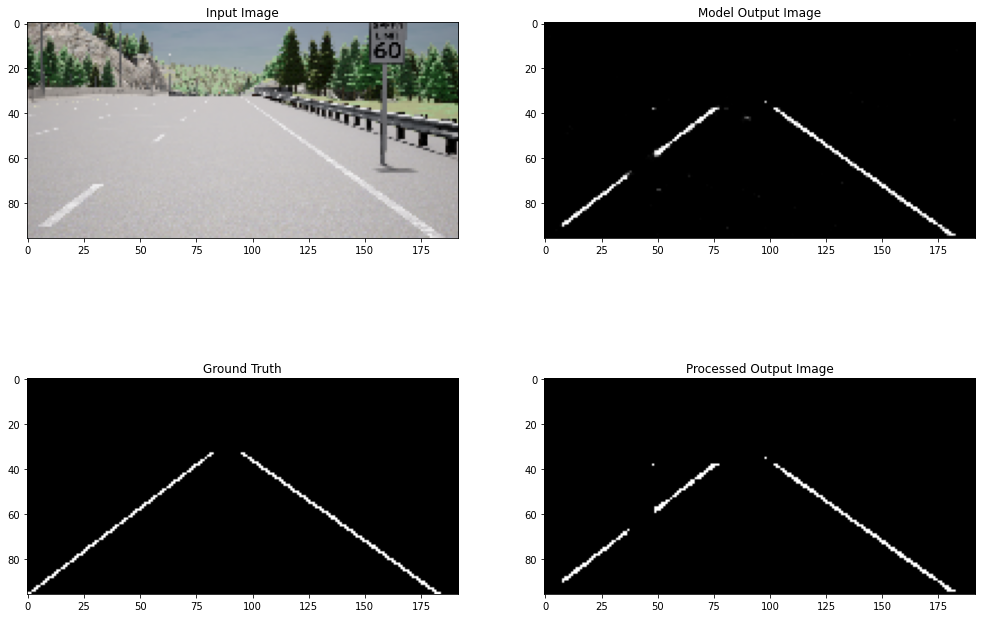

In [52]:
with torch.no_grad():
    ip = torch.from_numpy(val_x[sample_number]).float()
    ip = torch.unsqueeze(ip, axis = 0)
    ip = ip.to(device)
    # # changing from 10 x 96 x 192 x 3 to 10 x 3 x 96 x 192
    ip = ip.transpose(1, 3)
    ip = ip.transpose(2, 3)

    y_pred = model(ip)

    y_pred = y_pred[0]

    y_pred = y_pred.transpose(0, 1)
    y_pred = y_pred.transpose(1, 2)

    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()

    plt.figure()
    f, axarr = plt.subplots(2,2, figsize=(17, 12)) 

    t = np.where(y_pred >= 0.5, y_pred, 0)

    axarr[0][0].title.set_text("Input Image")
    axarr[0][0].imshow(val_x[sample_number])

    axarr[0][1].title.set_text("Model Output Image")
    axarr[0][1].imshow(y_pred*broad_caster)
    
    axarr[1][0].title.set_text("Ground Truth")
    axarr[1][0].imshow(val_ground[sample_number]*broad_caster*100)
    
    axarr[1][1].title.set_text("Processed Output Image")
    axarr[1][1].imshow(t * broad_caster * 100)